# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [6]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from datetime import datetime
import utils
import model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Set some parameters
_imgWidth = 256
_imgHeight = 256
_imgChannels = 3
_trainPath = './stage1_train_fixed/'
_valPath = './extra_data/'
_testPath = './stage2_test_final/'

# Root directory of the project
_rootDir = os.getcwd()

# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Get the data

Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!


In [19]:
#train_ids, X_train, Y_train = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, testData = False)
#val_ids, X_val, Y_val = utils.load_dataset(_valPath, _imgWidth, _imgHeight, _imgChannels, testData = False)
test_ids, X_test, sizes_test = utils.load_dataset(_testPath, _imgWidth, _imgHeight, _imgChannels, testData = True)

Getting and resizing images ... 


 11%|█         | 336/3021 [00:09<01:19, 33.66it/s]/opt/conda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
 16%|█▌        | 486/3021 [00:14<01:15, 33.60it/s]

646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0


 41%|████      | 1236/3021 [00:36<00:52, 33.83it/s]

__pycache__


 69%|██████▉   | 2087/3021 [01:01<00:27, 33.86it/s]

.ipynb_checkpoints


100%|█████████▉| 3018/3021 [01:28<00:00, 34.10it/s]

Done!
3015
3021
665
665


In [26]:
print(len(test_ids))
print(len(X_test))
print(len(sizes_test))

3018
3021
3015



Let's see if things look all right by drawing some random images and their associated masks.


/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


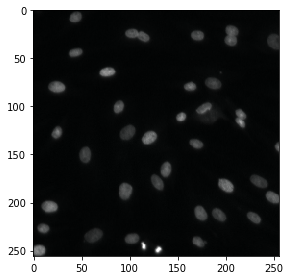

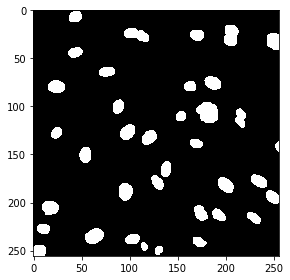

In [12]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


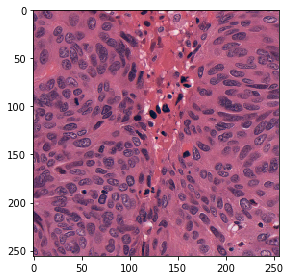

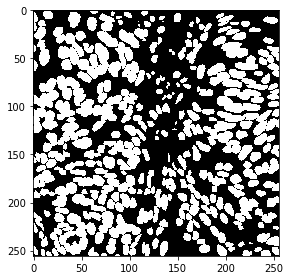

In [27]:
# Check if validation data looks all right
ix = random.randint(0, len(val_ids))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [14]:
u_net = model.build_model(_imgWidth, _imgWidth, _imgChannels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [13]:
#model.fit_model(u_net, _modelDir, _rootDir, X_train, Y_train)
model.fit_model_generator(u_net, _modelDir, _rootDir, X_train, Y_train, X_val, Y_val)

NameError: name 'u_net' is not defined

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [22]:
preds_train_t, preds_val_t, preds_test_upsampled = model.make_predictions('./logs/2018-05-20 18:48:03/epoch0030-val_loss0.44.h5', X_train, X_val, X_test, sizes_test)

3021/3021 [==============================] - 5s 2ms/step


IndexError: list index out of range

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


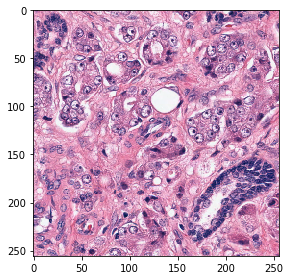

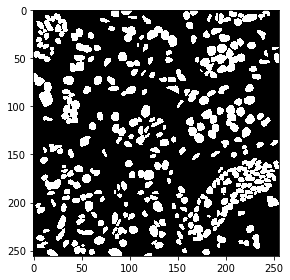

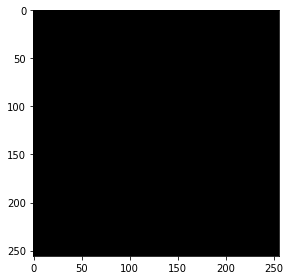

In [28]:
# Perform a sanity check on some random validation samples
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

and the test data:

/opt/conda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


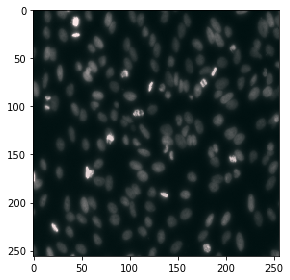

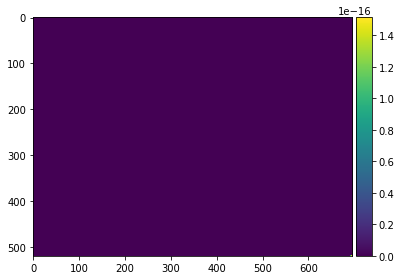

In [29]:
# Perform a sanity check on some random test sample
ix = random.randint(0, len(preds_test_upsampled))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_upsampled[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(utils.prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [26]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submissions/sub-dsbowl2018-U-Net_10.csv', index=False)